# Comparing Russell Funk's CD index data to Dimensions on GBQ calculations

Prerequisites for running this notebook:

* You need to have run the SQL to write the full CD index tables, as defined in the notebook **Calculating the CD index using Dimensions on Google BigQuery**, for all, journals and pubmed articles.
* You need to have access to the sample dataset from Russell Funk

For more details, see the accompanying **[README.md](https://github.com/digital-science/dimensions-gbq-lab/blob/master/archive/CD-index/README.md)**.

In [ ]:
import datetime
from time import sleep
from string import Template
import pandas as pd
import numpy as np
import re
import os
import shutil
import pandas as pd
import itertools
from textblob import Word # making singulars and plural
import tqdm
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

import gspread
from gspread_dataframe import set_with_dataframe
from google.colab import auth
from google.auth import default
from google.cloud import bigquery

from secrets import gbq_project_id, gbq_table_prefix

# Authenticate Google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Get the tables with all fields and nesting for the GBQ Dimensions tables
def gbq(sql, verbose=True):
  if verbose:
    print("==========\nQuerying:")
    print(sql)
    print("...")
  df = pd.io.gbq.read_gbq(sql, project_id = gbq_project_id, )
  if verbose:
    print("\t...loaded ", len(df), " records")
    display(df)
  return df


# Writing Funk's data to GBQ
We received large CSV files but in GBQ it will be easier for us to merge them and compare the results. Since we only need to do this once there are if-statements that avoid running these accidentally for no gain.

In [ ]:
# Only do this once if we get new data
write_funk_data = True
if write_funk_data:
  print("\n", "="*20)
  print("Reading WoS data...")
  wos_data = pd.read_csv("/content/wos_2017_cdindex_cross_20190711_sample_1M.csv.gz")
  print(f"...read {len(wos_data)} records")
  display(wos_data.head())
  display(wos_data.describe())
  print("Writing to GBQ...")
  wos_data.to_gbq(destination_table = f"{gbq_table_prefix}_wos_cds",
                   project_id = gbq_project_id, if_exists="replace")
  print("..done")

  print("\n", "="*20)
  print("Reading PubMed data...")
  pubmed_data = pd.read_csv("/content/pumbed_cdindex.csv")
  print(f"...read {len(pubmed_data)} records")
  display(pubmed_data.head())
  display(pubmed_data.describe())
  print("Writing to GBQ...")
  pubmed_data.to_gbq(destination_table = f"{gbq_table_prefix}_pubmed_cds",
                   project_id = gbq_project_id, if_exists="replace")
  print("..done")

write_merged_data = True
if write_merged_data:
  print("Merging ")
  query = f"""
  CREATE OR REPLACE TABLE `{gbq_project_id}.{gbq_table_prefix}_all`
  AS
  (
    SELECT DISTINCT
    publications.id,
    publications.doi,
    publications.pmid,
    publications.type,
    publications.year,
    publications.journal.id as journal_id,
    publications.journal.title as journal_title,
    publications.category_for.first_level.full[SAFE_OFFSET(0)].code AS for1_code,
    publications.category_for.first_level.full[SAFE_OFFSET(0)].name AS for1_name,
    publications.citations_count,
    ARRAY_LENGTH(publications.reference_ids) as reference_count,

    funk_pubmed.cd_5  AS funk_pubmed,
    funk_wos.cd_5     AS funk_wos,
    cd_all.cd_5       AS dim_all,
    cd_journals.cd_5  AS dim_journals,
    cd_pubmed.cd_5    AS dim_pubmed

    FROM `dimensions-ai.data_analytics.publications` AS publications
    LEFT JOIN `{gbq_project_id}.{gbq_table_prefix}_pubmed_cds`
      AS funk_pubmed
      ON funk_pubmed.pmid = CAST(publications.pmid AS INT64)
    LEFT JOIN  `{gbq_project_id}.{gbq_table_prefix}_wos_cds`
      AS funk_wos
      ON LOWER(funk_wos.doi_1) = LOWER(publications.doi)
    LEFT JOIN `reports-dimensions-ai.precomputed.publications_cd_index_all`
        AS cd_all
        ON publications.id = cd_all.id
    LEFT JOIN `reports-dimensions-ai.precomputed.publications_cd_index_journals`
        AS cd_journals
        ON publications.id = cd_journals.id
    LEFT JOIN `reports-dimensions-ai.precomputed.publications_cd_index_pubmed`
        AS cd_pubmed
        ON publications.id = cd_pubmed.id
  )
  """
  client = bigquery.Client(project=gbq_project_id)
  tmp = client.query(query)
  while not tmp.done():
    sleep(5)


Reading WoS data...
...read 1000000 records


,doi_1,cd_5,cd_10,cd_2017y,mcd_5,mcd_10,mcd_2017y,i_5,i_10,i_2017y
0,10.1016/j.biocel.2007.11.023,-0.006548,-0.004778,-0.004778,-0.157156,-0.171992,-0.171992,24,36,36
1,10.1021/ja028342n,-0.013873,-0.016844,-0.013982,-0.527168,-1.718108,-1.943540,38,102,139
2,10.1063/1.3681281,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0
3,10.2217/pme.14.21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0
4,10.1038/srep05937,-0.011321,-0.011321,-0.011321,-0.090566,-0.090566,-0.090566,8,8,8


,cd_5,cd_10,cd_2017y,mcd_5,mcd_10,mcd_2017y,i_5,i_10,i_2017y
count,849168.000000,850708.000000,850845.000000,849168.000000,850708.000000,850845.000000,1000000.000000,1000000.000000,1000000.000000
mean,0.008519,0.010897,0.011211,-0.069195,-0.058855,-0.044243,9.507605,13.280304,13.937364
std,0.123345,0.127708,0.128056,6.377573,7.878026,8.315393,24.510784,38.445551,42.469808
min,-1.000000,-1.000000,-1.000000,-873.182094,-1111.005892,-1111.005892,0.000000,0.000000,0.000000
25%,-0.007624,-0.006957,-0.006815,-0.071429,-0.080603,-0.080341,1.000000,1.000000,1.000000
50%,-0.001353,-0.001222,-0.001186,-0.006601,-0.006928,-0.006803,4.000000,4.000000,4.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,14.000000,14.000000
max,1.000000,1.000000,1.000000,4208.334940,5217.332501,5217.332501,6157.000000,8906.000000,9701.000000


Writing to GBQ...


100%|██████████| 1/1 [00:00<00:00, 1615.06it/s]


..done

Reading PubMed data...
...read 2326844 records


,pmid,cd_5,cd_10,cd_2018y
0,26568947,0.000000,NaN,0.000000
1,26568948,-0.001963,NaN,-0.001963
2,26579237,-0.090909,NaN,-0.090909
3,26579238,-0.003049,NaN,-0.003049
4,26579241,0.007299,NaN,0.007299


,pmid,cd_5,cd_10,cd_2018y
count,2.326844e+06,2.326844e+06,1.219550e+06,2.326844e+06
mean,1.617132e+07,-5.868535e-03,-1.904228e-03,1.117125e-03
std,7.250700e+06,1.100723e-01,1.215285e-01,8.033711e-02
min,7.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,1.055937e+07,-1.522843e-02,-1.785714e-02,-9.162717e-03
50%,1.879478e+07,-3.827751e-03,-4.166667e-03,-2.312673e-03
75%,2.208564e+07,-2.840859e-04,-9.121695e-05,0.000000e+00
max,3.052461e+07,1.000000e+00,1.000000e+00,1.000000e+00


Writing to GBQ...


100%|██████████| 1/1 [00:00<00:00, 7013.89it/s]


..done
Merging 


In [ ]:
cd_columns = [
    "funk_pubmed",
    "funk_wos",
    "dim_all",
    "dim_journals",
    "dim_pubmed"]

## Statistical attributes over each table

In [ ]:
all_stats = pd.DataFrame()
for cd_column in cd_columns:
  sql = f"""
  SELECT
    COUNT(DISTINCT id) AS count,
    MIN({cd_column}) AS min,
    MAX({cd_column}) AS max,
    AVG({cd_column}) AS mean,
    STDDEV({cd_column}) AS std,
    APPROX_QUANTILES({cd_column}, 100) AS quantiles
  FROM `{gbq_project_id}.{gbq_table_prefix}_all`
  WHERE {cd_column} IS NOT NULL
  """
  tmp = gbq(sql, False)
  tmp["source"] = cd_column
  all_stats = pd.concat([all_stats, tmp], axis=0)
for q in [0,25,50,75,95,99,100]:
  all_stats[f"q_{q}"] = all_stats['quantiles'].apply(lambda x: x[q])
all_stats.drop(columns=["quantiles"], inplace=True)
all_stats.set_index("source", inplace=True)
all_stats

,count,min,max,mean,std,q_0,q_25,q_50,q_75,q_95,q_99,q_100
source,,,,,,,,,,,,
funk_pubmed,2326769,-1.0,1.0,-0.005869,0.110063,-1.0,-0.015267,-0.003831,-0.000283,0.036232,0.45,1.0
funk_wos,836578,-1.0,1.0,0.008392,0.122788,-1.0,-0.007634,-0.001356,0.000000,0.023622,1.00,1.0
dim_all,79090848,-1.0,1.0,0.171105,0.380231,-1.0,-0.002303,0.000000,0.005556,1.000000,1.00,1.0
dim_journals,38612146,-1.0,1.0,0.003999,0.084535,-1.0,-0.005952,-0.000690,0.000000,0.029126,0.30,1.0
dim_pubmed,28165365,-1.0,1.0,0.154927,0.366095,-1.0,-0.004484,-0.000181,0.004448,1.000000,1.00,1.0


In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
display(all_stats)

,count,min,max,mean,std,q_0,q_25,q_50,q_75,q_95,q_99,q_100
source,,,,,,,,,,,,
funk_pubmed,2326769,-1.00,1.00,-0.01,0.11,-1.00,-0.02,-0.00,-0.00,0.04,0.45,1.00
funk_wos,836578,-1.00,1.00,0.01,0.12,-1.00,-0.01,-0.00,0.00,0.02,1.00,1.00
dim_all,79090848,-1.00,1.00,0.17,0.38,-1.00,-0.00,0.00,0.01,1.00,1.00,1.00
dim_journals,38612146,-1.00,1.00,0.00,0.08,-1.00,-0.01,-0.00,0.00,0.03,0.30,1.00
dim_pubmed,28165365,-1.00,1.00,0.15,0.37,-1.00,-0.00,-0.00,0.00,1.00,1.00,1.00


## Histograms for all CD indices

In [ ]:
all_hist = pd.DataFrame()
for cd_column in cd_columns:
  sql = f"""
  SELECT
    ROUND({cd_column}*100,0)/100 AS cd,
    COUNT(DISTINCT id) AS nr_publications,
  FROM `{gbq_project_id}.{gbq_table_prefix}_all`
  WHERE {cd_column} IS NOT NULL
  GROUP BY 1
  ORDER BY 1 ASC
  """
  tmp = gbq(sql, False)
  tmp["source"] = cd_column
  all_hist = pd.concat([all_hist, tmp], axis=0)
all_hist

,cd,nr_publications,source
0,-1.00,4263,funk_pubmed
1,-0.96,1,funk_pubmed
2,-0.94,1,funk_pubmed
3,-0.91,1,funk_pubmed
4,-0.89,2,funk_pubmed
...,...,...,...
194,0.96,229,dim_pubmed
195,0.97,156,dim_pubmed
196,0.98,95,dim_pubmed
197,0.99,32,dim_pubmed


In [ ]:
all_hist.to_csv("cd_histogram.csv")

fig = px.line(all_hist, x="cd", y="nr_publications", color="source",  width=1400,
              labels={
                     "cd": "CD",
                     "nr_publications": "Publications",
                     "source": "Source"
                 }
      )

fig.update_layout(
    font=dict(size=18),
    legend=dict(
          yanchor="top",
          y=0.99,
          xanchor="left",
          x=0.01
        )
    )

fig.show()

## Distribution over publiction year


In [ ]:
all_trends = pd.DataFrame()
for cd_column in cd_columns:
  sql = f"""
  SELECT
    year,
    AVG({cd_column}) as average_cd
  FROM `{gbq_project_id}.{gbq_table_prefix}_all`
  WHERE {cd_column} IS NOT NULL
  GROUP BY 1
  ORDER BY 1 ASC
  """
  tmp = gbq(sql, False)
  tmp["source"] = cd_column
  all_trends = pd.concat([all_trends, tmp], axis=0)
all_trends

,year,average_cd,source
0,1930,0.18,funk_pubmed
1,1931,0.15,funk_pubmed
2,1932,0.20,funk_pubmed
3,1933,0.16,funk_pubmed
4,1934,0.17,funk_pubmed
...,...,...,...
157,2019,0.05,dim_pubmed
158,2020,0.04,dim_pubmed
159,2021,0.03,dim_pubmed
160,2022,0.02,dim_pubmed


In [ ]:
fig = px.line(all_trends[(all_trends.year>=1945) & (all_trends.year<=2010) ], x="year", y="average_cd", facet_col="source" )
fig.show()

In [ ]:
plotted_trends = all_trends[(all_trends.year>=1945) & (all_trends.year<=2010) & all_trends.source.str.startswith("dim_")]
plotted_trends.to_csv("cd_trends.csv")
fig = px.line(plotted_trends, x="year", y="average_cd", color="source", width=1000,
              labels ={
                  "year" : "Year",
                  "average_cd" : "Mean CD",
                  "source" : "Source"
              })
fig.update_layout(
    font=dict(size=14),
    legend=dict(
          yanchor="top",
          y=0.99,
          xanchor="right",
          x=0.99
              )
    )

fig.show()

## Are disruptive PubMed papers of Funk and Dimension the same?

In [ ]:
top_n=20000
sql = f"""
DECLARE top_n INT64 DEFAULT {top_n};
WITH raw_data AS
(
  SELECT
  id,
  dim_pubmed,
  ROW_NUMBER() OVER(ORDER BY dim_pubmed DESC) as rk_dim_pubmed,
  funk_pubmed,
  ROW_NUMBER() OVER(ORDER BY funk_pubmed DESC) as rk_funk_pubmed,

  FROM `ds-data-solutions-gbq.joerg.funk_all` as fall
  WHERE fall.dim_pubmed IS NOT NULL AND fall.funk_pubmed IS NOT NULL
)

SELECT MIN(dim_pubmed) AS min_dim_pubmed, MIN(funk_pubmed) AS min_funk_pubmed,
 COUNT(DISTINCT id ) as nr_overlap

FROM raw_data
WHERE rk_dim_pubmed <= top_n AND rk_funk_pubmed <= top_n
"""
tmp = gbq(sql,verbose=False).iloc[0]

In [ ]:
print(f"In the top {top_n} disruptive papers in original and gbq pubmed publications we have {tmp.nr_overlap/top_n:.2%} overlap")

In the top 20000 disruptive papers in original and gbq pubmed publications we have 68.42% overlap


In [ ]:
sql="""
  SELECT
  dim_pubmed,
  funk_pubmed,
  FROM `ds-data-solutions-gbq.joerg.funk_all` as fall
  WHERE fall.dim_pubmed IS NOT NULL AND fall.funk_pubmed IS NOT NULL
"""
tmp =gbq(sql)

Querying:

  SELECT
  dim_pubmed,
  funk_pubmed,
  FROM `ds-data-solutions-gbq.joerg.funk_all` as fall
  WHERE fall.dim_pubmed IS NOT NULL AND fall.funk_pubmed IS NOT NULL

...
	...loaded  2326710  records


,dim_pubmed,funk_pubmed
0,-0.01,-0.11
1,-0.02,-0.02
2,-0.00,-0.01
3,-0.02,-0.03
4,0.09,0.21
...,...,...
2326705,-0.00,0.00
2326706,-0.02,0.00
2326707,0.01,0.00
2326708,-0.00,0.00


<Axes: xlabel='dim_pubmed', ylabel='funk_pubmed'>

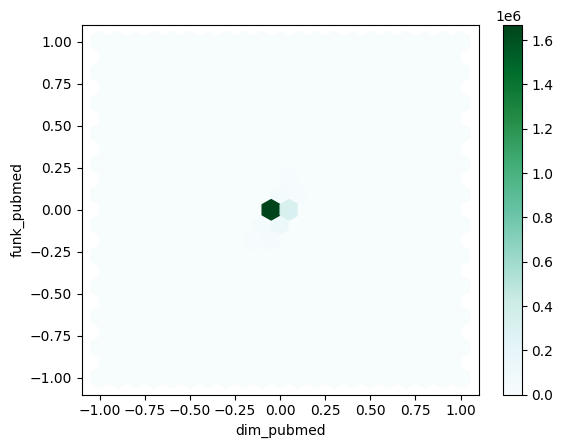

In [ ]:
tmp.plot(kind='hexbin', x='dim_pubmed', y='funk_pubmed', gridsize = 20)

Divide up all papers into three categories for Funk's and mine CD
Disruptive:
	 Funk CD: highest 1.0% of publications i.e. Funk CD_5 > 0.5 
	 My CD:   highest 1.0% of publications i.e. My CD_5 > 0.2 
Consolidating:
	 Funk CD: lowest 1.0% of publications i.e. Funk CD_5 < -0.2 
	 My CD:   lowest 1.0% of publications i.e. My CD_5 < -0.1 
Neutral: everything in the middle


dim_pubmed                                funk_pubmed  \
my_class      consolidating  neutral disruptive      All consolidating   
funk_class                                                               
consolidating         12306    15357        607    28270         12306   
neutral               10638  2256619       7946  2275203         10638   
disruptive              416     8113      14708    23237           416   
All                   23360  2280089      23261  2326710         23360   

                                            
my_class       neutral disruptive      All  
funk_class                                  
consolidating    15357        607    28270  
neutral        2256619       7946  2275203  
disruptive        8113      14708    23237  
All            2280089      23261  2326710

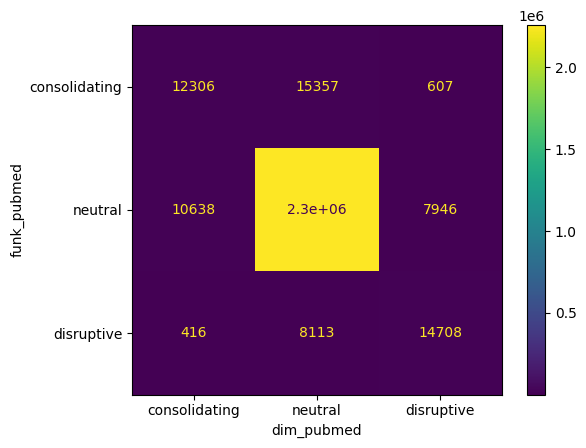

In [ ]:
q=0.01

print(f"Divide up all papers into three categories for Funk's and mine CD")
print(f"Disruptive:")
print(f"\t Funk CD: highest {q:0.1%} of publications i.e. Funk CD_5 > {tmp.funk_pubmed.quantile(1-q):.1} ")
print(f"\t My CD:   highest {q:0.1%} of publications i.e. My CD_5 > {tmp.dim_pubmed.quantile(1-q):.1} ")
print(f"Consolidating:")
print(f"\t Funk CD: lowest {q:0.1%} of publications i.e. Funk CD_5 < {tmp.funk_pubmed.quantile(q):.1} ")
print(f"\t My CD:   lowest {q:0.1%} of publications i.e. My CD_5 < {tmp.dim_pubmed.quantile(q):.1} ")
print(f"Neutral: everything in the middle")


tmp["funk_class"]=pd.qcut(tmp.funk_pubmed,   [0, q, 1-q, 1],     labels=["consolidating", "neutral", "disruptive"])
tmp["my_class"]  =pd.qcut(tmp.dim_pubmed,    [0, q,   1-q,   1], labels=["consolidating", "neutral", "disruptive"])
display(pd.pivot_table(tmp, index="funk_class", columns="my_class", aggfunc="count", margins=True))
ConfusionMatrixDisplay.from_predictions(tmp["funk_class"], tmp["my_class"], labels = ["consolidating", "neutral", "disruptive"])
color = 'black'
plt.ylabel('funk_pubmed', color=color)
plt.xlabel('dim_pubmed', color=color)
plt.show()

In [ ]:
print(classification_report(tmp["funk_class"], tmp["my_class"], digits=2))

               precision    recall  f1-score   support

consolidating       0.53      0.44      0.48     28270
   disruptive       0.63      0.63      0.63     23237
      neutral       0.99      0.99      0.99   2275203

     accuracy                           0.98   2326710
    macro avg       0.72      0.69      0.70   2326710
 weighted avg       0.98      0.98      0.98   2326710

